In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np

import fastai as meta_fai
import fastai.vision as fv
import fastai.basics as fai
import fastai.fastai_audio as fa

from pathlib import Path
from IPython.display import Audio

In [3]:
path_good   = Path("Clean/")
path_crappy = Path("Noise/")
path        = Path("../models/")

In [4]:
def file_name(path:Path):
    file_name = path.relative_to(path_crappy)
    file_name = path_good/file_name
    return file_name.with_suffix(".wav")

In [5]:
def load_data(batch_size, amount=1., n_fft=2046, n_hop=512):
    tfms = fa.get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop, decibels=False, mult_padding=16)
    data = (fa.AudioAudioList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .split_by_rand_pct(0.2)
            .label_from_func(file_name)
            .databunch(bs=batch_size, tfms=tfms))
    return data

In [6]:
data = load_data(1, amount=1)

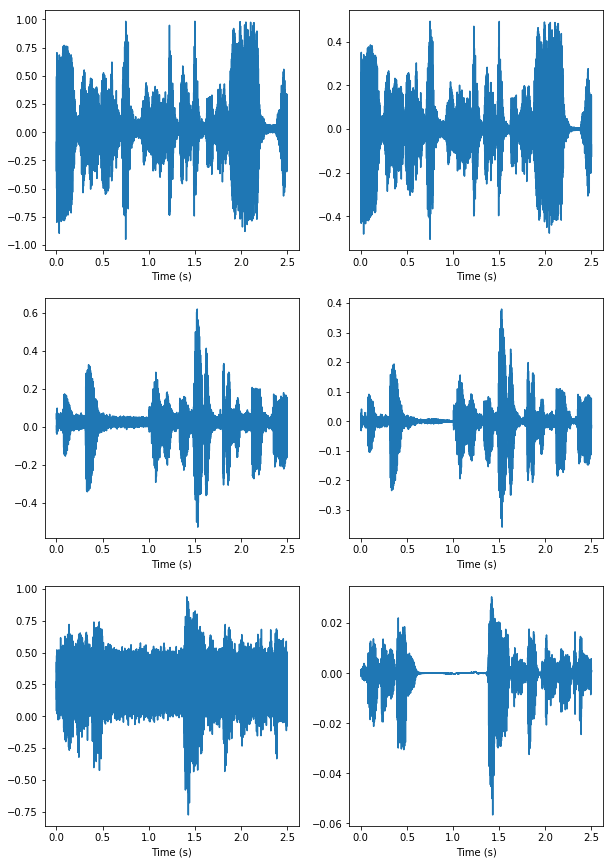

<Figure size 432x288 with 0 Axes>

In [7]:
data.show_batch(3);

In [8]:
def l1_loss_flat(a,b):
    return F.l1_loss(a.squeeze(), b.squeeze())

In [9]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, 
                           blur=True, norm_type=fai.NormType.Weight, 
                           self_attention=True, y_range=(-3.,3.), 
                           loss_func=l1_loss_flat, wd=1e-2)

In [12]:
learn = create_learner(data)

In [13]:
learn.model_dir = path

In [14]:
learn.model[0][0]     = nn.Sequential(nn.Conv2d(2,  64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
learn.model[10][0][0] = nn.Sequential(nn.Conv2d(98, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
learn.model[10][1][0] = nn.Sequential(nn.Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
learn.model[11][0]    = nn.Sequential(nn.Conv2d(98, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                                      nn.Conv2d(99, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#learn.model[12]       = nn.Sequential(nn.Conv2d(99, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [15]:
learn.model.cuda(0);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


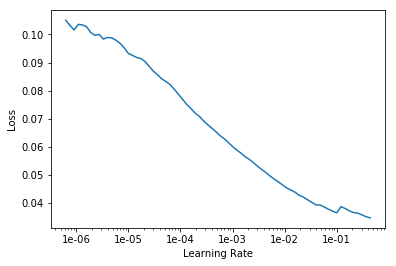

In [16]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 7e-2)

In [13]:
learn.save("TESTING")

In [17]:
learn.load("3epoch_8bs");

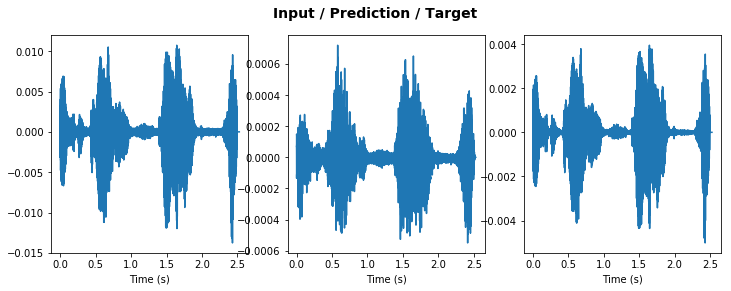

<Figure size 432x288 with 0 Axes>

In [18]:
learn.show_results(1)

In [26]:
data.dl().dl

In [23]:
data.dl().dl.get(0)

AudioClip (Audio:Noise/2ksLtAPcsiE.wav, duration=2.5s, sample_rate=22.1KHz)

In [28]:
while next(iter(data.dl().dl)):
    print(x)

[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6e44d6cf28>>
Traceback (most recent call last):
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.0609, -0.0655]])]
[tensor([[ 0.0457,  0.0936,  0.0915,  ..., -0.0924, -0.0830, -0.1010]]), tensor([[ 0.0396,  0.0622,  0.0598,  ..., -0.0630, -0.060

KeyboardInterrupt: 

In [29]:
len(data.dl().dl)

214

In [ ]:
while True:
    x = data.dl().dl
    